In [1]:
# modules
import tifffile as tif
import h5py
import numpy as np
import volumentations as vol
import matplotlib.pyplot as plt
import os
import copy
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader

In [23]:
# training parameters
parameter = {
    "model": "UNet11",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 1,
    "num_workers": 8,
    "epochs": 10,
    "padded_size" : (256, 768, 768),
    "patch_size" : (128, 128, 128)
    }

In [13]:
# load data
# raw
# masks
# weight (or generate on the fly)

In [8]:
# set image and mask directories
images_dir = '../dataset_exp50.1/train/raw/'
masks_dir = '../dataset_exp50.1/train/labels/'

In [10]:
# image and mask filenames sorted
images_filenames = np.sort([f for f in os.listdir(images_dir) if f.endswith('.tif')])
masks_filenames = np.sort([f for f in os.listdir(masks_dir) if f.endswith('.h5')])

In [11]:
# check data and masks
def check(images_filesnames, images_dir, masks_filenames, masks_dir, idx=0, z_slice=52):
    image = tif.imread(files=images_dir + images_filenames[idx])
    mask_h5 = h5py.File(masks_dir + masks_filenames[idx], 'r')
    mask = np.squeeze(np.asarray(mask_h5['exported_data']))
    figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].imshow(image[z_slice])
    ax[1].imshow(mask[z_slice])
    ax[0].set_title('image')
    ax[1].set_title('mask')
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    plt.tight_layout()
    plt.show()

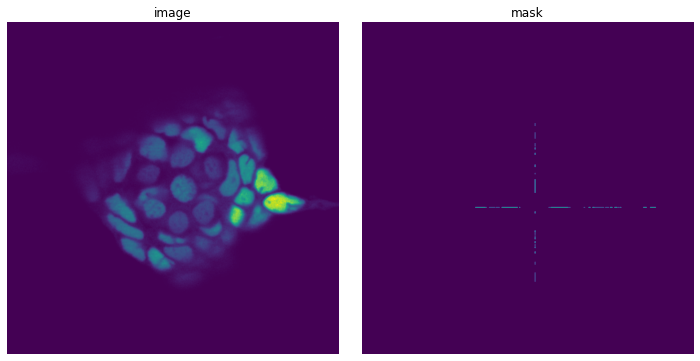

In [12]:
check(images_filenames, images_dir, masks_filenames, masks_dir, idx=0)

In [24]:
# define training augmentation pipeline
augmentation_train = vol.Compose([
        vol.PadIfNeeded(shape=parameter['padded_size'], border_mode='reflect')
        ])

# define validation augmentation pipeline
augmentation_val = vol.Compose([
        vol.PadIfNeeded(shape=parameter['padded_size'], border_mode='reflect')
        ])

# define test augmentation pipeline
augmentation_test = vol.Compose([
        vol.PadIfNeeded(shape=parameter['padded_size'], border_mode='reflect')
        ])

In [25]:
# custom dataset class
# add slicing
class Dataset_3d():
    ''' Accepts list of filenames and directories, loads, transforms and returns upon calling
        getitem.'''
    def __init__(self, images_filenames, images_dir, masks_filenames, masks_dir, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_dir
        self.masks_filenames = masks_filenames
        self.masks_directory = masks_dir
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = tif.imread(os.path.join(self.images_directory, image_filename))
        mask_filename = self.masks_filenames[idx]
        mask_h5 = h5py.File(os.path.join(self.masks_directory, mask_filename), 'r')
        mask = np.squeeze(np.array(mask_h5['exported_data']))
        
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        return image, mask

In [26]:
# instantiate training, validation and test dataset
# divide images in train, val and test pieces
train_ds = Dataset_3d(images_filenames, images_dir, masks_filenames, 
                      masks_dir, transform=augmentation_train)

train_val = None
train_test = None

In [43]:
class SliceBuilder:
    """
    Builds the position of the patches in a given raw/label/weight ndarray based on the the patch and stride shape
    """

    def __init__(self, raw_datasets, label_datasets, weight_dataset, patch_shape, stride_shape, **kwargs):
        """
        :param raw_datasets: ndarray of raw data
        :param label_datasets: ndarray of ground truth labels
        :param weight_dataset: ndarray of weights for the labels
        :param patch_shape: the shape of the patch DxHxW
        :param stride_shape: the shape of the stride DxHxW
        :param kwargs: additional metadata
        """

        patch_shape = tuple(patch_shape)
        stride_shape = tuple(stride_shape)
        skip_shape_check = kwargs.get('skip_shape_check', False)
        if not skip_shape_check:
            self._check_patch_shape(patch_shape)

        self._raw_slices = self._build_slices(raw_datasets[0], patch_shape, stride_shape)
        if label_datasets is None:
            self._label_slices = None
        else:
            # take the first element in the label_datasets to build slices
            self._label_slices = self._build_slices(label_datasets[0], patch_shape, stride_shape)
            assert len(self._raw_slices) == len(self._label_slices)
        if weight_dataset is None:
            self._weight_slices = None
        else:
            self._weight_slices = self._build_slices(weight_dataset[0], patch_shape, stride_shape)
            assert len(self.raw_slices) == len(self._weight_slices)

    @property
    def raw_slices(self):
        return self._raw_slices

    @property
    def label_slices(self):
        return self._label_slices

    @property
    def weight_slices(self):
        return self._weight_slices

    @staticmethod
    def _build_slices(dataset, patch_shape, stride_shape):
        """Iterates over a given n-dim dataset patch-by-patch with a given stride
        and builds an array of slice positions.

        Returns:
            list of slices, i.e.
            [(slice, slice, slice, slice), ...] if len(shape) == 4
            [(slice, slice, slice), ...] if len(shape) == 3
        """
        slices = []
        if dataset.ndim == 4:
            in_channels, i_z, i_y, i_x = dataset.shape
        else:
            i_z, i_y, i_x = dataset.shape

        k_z, k_y, k_x = patch_shape
        s_z, s_y, s_x = stride_shape
        z_steps = SliceBuilder._gen_indices(i_z, k_z, s_z)
        for z in z_steps:
            y_steps = SliceBuilder._gen_indices(i_y, k_y, s_y)
            for y in y_steps:
                x_steps = SliceBuilder._gen_indices(i_x, k_x, s_x)
                for x in x_steps:
                    slice_idx = (
                        slice(z, z + k_z),
                        slice(y, y + k_y),
                        slice(x, x + k_x)
                    )
                    if dataset.ndim == 4:
                        slice_idx = (slice(0, in_channels),) + slice_idx
                    slices.append(slice_idx)
        return slices

    @staticmethod
    def _gen_indices(i, k, s):
        assert i >= k, 'Sample size has to be bigger than the patch size'
        for j in range(0, i - k + 1, s):
            yield j
        if j + k < i:
            yield i - k

    @staticmethod
    def _check_patch_shape(patch_shape):
        assert len(patch_shape) == 3, 'patch_shape must be a 3D tuple'
        assert patch_shape[1] >= 64 and patch_shape[2] >= 64, 'Height and Width must be greater or equal 64'


class FilterSliceBuilder(SliceBuilder):
    """
    Filter patches containing more than `1 - threshold` of ignore_index label
    """

    def __init__(self, raw_datasets, label_datasets, weight_datasets, patch_shape, stride_shape, ignore_index=(0,),
                 threshold=0.6, slack_acceptance=0.01, **kwargs):
        super().__init__(raw_datasets, label_datasets, weight_datasets, patch_shape, stride_shape, **kwargs)
        if label_datasets is None:
            return

        rand_state = np.random.RandomState(47)

        def ignore_predicate(raw_label_idx):
            label_idx = raw_label_idx[1]
            patch = np.copy(label_datasets[0][label_idx])
            for ii in ignore_index:
                patch[patch == ii] = 0
            non_ignore_counts = np.count_nonzero(patch != 0)
            non_ignore_counts = non_ignore_counts / patch.size
            return non_ignore_counts > threshold or rand_state.rand() < slack_acceptance

        zipped_slices = zip(self.raw_slices, self.label_slices)
        # ignore slices containing too much ignore_index
        filtered_slices = list(filter(ignore_predicate, zipped_slices))
        # unzip and save slices
        raw_slices, label_slices = zip(*filtered_slices)
        self._raw_slices = list(raw_slices)
        self._label_slices = list(label_slices)

In [54]:
slicebuilder = FilterSliceBuilder(np.expand_dims(train_ds[0][0], axis=0),
                                  np.expand_dims(train_ds[0][1], axis=0), None,
                                  parameter['patch_size'], parameter['patch_size'],
                                 threshold=0.001)

In [55]:
slicebuilder.label_slices

[(slice(0, 128, None), slice(128, 256, None), slice(384, 512, None)),
 (slice(0, 128, None), slice(256, 384, None), slice(128, 256, None)),
 (slice(0, 128, None), slice(256, 384, None), slice(256, 384, None)),
 (slice(0, 128, None), slice(256, 384, None), slice(384, 512, None)),
 (slice(0, 128, None), slice(256, 384, None), slice(512, 640, None)),
 (slice(0, 128, None), slice(384, 512, None), slice(128, 256, None)),
 (slice(0, 128, None), slice(384, 512, None), slice(256, 384, None)),
 (slice(0, 128, None), slice(384, 512, None), slice(384, 512, None)),
 (slice(0, 128, None), slice(384, 512, None), slice(512, 640, None)),
 (slice(0, 128, None), slice(640, 768, None), slice(256, 384, None)),
 (slice(128, 256, None), slice(128, 256, None), slice(384, 512, None)),
 (slice(128, 256, None), slice(256, 384, None), slice(128, 256, None)),
 (slice(128, 256, None), slice(256, 384, None), slice(256, 384, None)),
 (slice(128, 256, None), slice(256, 384, None), slice(384, 512, None)),
 (slice(128,

In [57]:
len(FilterSliceBuilder._build_slices(train_ds[0][0], parameter['patch_size'], parameter['patch_size']))

72

In [37]:
# def dataset visualisation fx
def visualize_augmentations(dataset, idx=0, samples=2, z_slice=128):
    #dataset = copy.deepcopy(dataset)
    #dataset.transform = vol.Compose([t for t in dataset.transform if not isinstance(t, (vol.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(5, 12))
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image[z_slice])
        ax[i, 1].imshow(mask[z_slice], interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

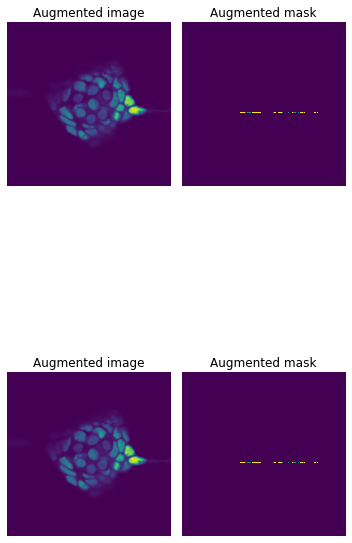

In [38]:
# plot training dataset augmentations
visualize_augmentations(train_ds)

In [58]:
# define a training data loader
train_loader = DataLoader(
        train_ds,
        batch_size=params["batch_size"],
        shuffle=True,
        num_workers=params["num_workers"],
        pin_memory=True)

In [59]:
# check
def check_loader(train_loader):
    train_img, train_mask = next(iter(train_loader))
    figure, ax = plt.subplots(train_img.shape[0], 2, figsize=(5, 12))
    for i in range(0, train_img.shape[0]):
        ax[i, 0].imshow(train_img[i, 68])
        ax[i, 1].imshow(train_mask[i, 68])
    plt.show()

In [ ]:
check_loader(train_loader)

In [ ]:
# define a model

In [ ]:
# define training fx